# Collision avoidance — drone

## Setup

Import modules.

In [377]:
import numpy as np
from sympy import *
import sympy as sym
import matplotlib.pyplot as plt
import scipy.linalg as linalg

import secrets
import ae353_drone
#import ae353_dronecontrol           # <--- must have a working controller

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results.

In [378]:
seed = secrets.randbits(32)
print(seed)

1823831506


Create simulator with seed.

In [379]:
simulator = ae353_drone.Simulator(seed=seed, display=True)

Add camera views, displayed in their own browser windows.

In [380]:
# Start view
simulator.add_view('my_start_view', 'start')

# Ring 1 view
#simulator.add_ring_view('my_ring_view', 1)

# Top view
#simulator.add_view('my_top_view', 'top')

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


Allow print statements and long computation times (only for development).

In [381]:
simulator.set_rules(
    error_on_print=False,
    error_on_timeout=False,
    error_on_inactive=False,
)

In [382]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

In [383]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

In [384]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

In [385]:
m = np.array([p_x,p_y,p_z,psi,theta,phi,v_x, v_y,v_z,w_x,w_y,w_z])
n = np.array([tau_x,tau_y,tau_z,f_z])

p_xe = p_ye = p_ze = psi_e = theta_e = phi_e = v_xe = v_ye = v_ze =  w_xe = w_ye = w_ze = 0.
tau_xe = tau_ye = tau_ze = 0.
f_ze = 4.905
A = np.array(f.jacobian(m).subs({p_x:p_xe,p_y:p_ye,p_z:p_ze,psi:psi_e,theta:theta_e,phi:phi_e,v_x:v_xe,v_y:v_ye,v_z:v_ze,w_x:w_xe,w_y:w_ye,w_z:w_ze,\
                        tau_x:tau_xe,tau_y:tau_ye,tau_z:tau_ze,f_z:f_ze})).astype(np.float64)
B = np.array(f.jacobian(n).subs({p_x:p_xe,p_y:p_ye,p_z:p_ze,psi:psi_e,theta:theta_e,phi:phi_e,v_x:v_xe,v_y:v_ye,v_z:v_ze,w_x:w_xe,w_y:w_ye,w_z:w_ze,\
                        tau_x:tau_xe,tau_y:tau_ye,tau_z:tau_ze,f_z:f_ze})).astype(np.float64)
print(A)
print(B)
W_c = np.block([B,A@B,np.linalg.matrix_power(A,2)@B,np.linalg.matrix_power(A,3)@B,
                np.linalg.matrix_power(A,4)@B,np.linalg.matrix_power(A,5)@B,np.linalg.matrix_power(A,6)@B,np.linalg.matrix_power(A,7)@B,
                np.linalg.matrix_power(A,8)@B,np.linalg.matrix_power(A,9)@B,np.linalg.matrix_power(A,10)@B,np.linalg.matrix_power(A,11)@B])
print(f'W_c rank: {np.linalg.matrix_rank(W_c)}, col num: {A.shape[0]}')

[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
[[  0.          0.          0.          0.       ]
 [  0.          0.          0.          0.      

In [386]:
m = sym.Matrix([p_x,p_y,p_z,psi,theta,phi,v_x, v_y,v_z,w_x,w_y,w_z])
n = sym.Matrix([tau_x,tau_y,tau_z,f_z])
C_sym = g.jacobian(m)
D_sym = g.jacobian(n)

subs_dict = {
    p_x: 0.0, p_y: 0.0, p_z: 0.0,
    psi: 0.0, theta: 0.0, phi: 0.0,
    v_x: 0.0, v_y: 0.0, v_z: 0.0,
    w_x: 0.0, w_y: 0.0, w_z: 0.0
}
C_eval = C_sym.evalf(subs=subs_dict)
D_eval = D_sym.evalf(subs=subs_dict)

C = np.array(C_eval.tolist()).astype(np.float64)
D = np.array(D_eval.tolist()).astype(np.float64)
print(C)
print(D)

W_o = np.block([[C],[C@A], [C@np.linalg.matrix_power(A,2)],[C@np.linalg.matrix_power(A,3)],\
                 [C@np.linalg.matrix_power(A,4)],[C@np.linalg.matrix_power(A,5)], [C@np.linalg.matrix_power(A,6)],
                 [C@np.linalg.matrix_power(A,7)], [C@np.linalg.matrix_power(A,8)], [C@np.linalg.matrix_power(A,9)],
                 [C@np.linalg.matrix_power(A,10)], [C@np.linalg.matrix_power(A,11)]])
print(f'W_o rank: {np.linalg.matrix_rank(W_o)}, col num: {A.shape[0]}')

[[ 1.     0.     0.    -0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.     0.175  0.     0.     0.     0.
   0.     0.   ]
 [ 1.     0.     0.     0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.    -0.175  0.     0.     0.     0.
   0.     0.   ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
W_o rank: 12, col num: 12


In [387]:
Qc = np.diag([1,1,1,10,10,10,.1,.1,.1,1,1,1])
Rc = np.diag([100,100,100,5])


Pc = linalg.solve_continuous_are(A,B,Qc,Rc)
K = linalg.inv(Rc)@B.T@Pc
Ro = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
Qo = np.diag([1,1,1,1,1,1])

def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K


K = lqr(A, B, Qc, Rc)
L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

print(f'K matrix')
print(K)
print(f'L matrix')
print(L)

K matrix
[[-0.         -0.1         0.          0.         -0.          0.58989632
  -0.         -0.11413338  0.          0.11275426 -0.          0.        ]
 [ 0.1         0.         -0.         -0.          0.58989632  0.
   0.11413338  0.          0.         -0.          0.11275426 -0.        ]
 [-0.         -0.         -0.          0.31622777 -0.          0.
  -0.         -0.         -0.          0.         -0.          0.11193669]
 [ 0.         -0.          0.4472136   0.          0.          0.
   0.         -0.          0.68353024  0.          0.         -0.        ]]
L matrix
[[ 2.97537602 -0.          0.          2.97537602 -0.         -0.        ]
 [-0.          2.92711379 -0.21976816 -0.          2.92711379  0.21976816]
 [ 0.          0.          1.09868411 -0.          0.          1.09868411]
 [-2.13087076  0.         -0.          2.13087076  0.          0.        ]
 [ 1.30543174 -0.          0.          1.30543174 -0.         -0.        ]
 [ 0.         -1.25581808  0.30429

Show controller template. The actual controller used in this example comes from `ae353_dronecontrol.py`.

**NOTE. I didn't publish the version of `ae353_dronecontrol.py` that was used in class, rather just the template version. If you want this notebook to work, you'll need to modify `ae353_dronecontrol.py` so that it works!**

## Trying Without Collision Avoidance

In [423]:
import numpy as np

class Controller:
    def __init__(self):

        # System matrices and LQR/Observer gains
        self.A = np.array([[  0,   0,   0,   0,   0,   0,   1,   0,   0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0  ],
            [ 0,    0,    0,    0,    9.81,  0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,   -9.81,  0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ]])
        self.B = np.array([[  0,          0,          0,          0      ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          2       ],
            [434.7826087,   0,          0,          0       ],
            [  0,        434.7826087,   0,          0       ],
            [  0,          0,        250,          0      ]])
        self.C = np.array([[ 1,     0,     0,    -0.175,  0,     0,     0,     0,     0,     0,
            0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0   ],
            [ 0,     0,     1,     0,     0,     0.175,  0,     0,     0,     0,
            0,     0   ],
            [ 1,     0,     0,     0.175,  0,     0,     0,     0,     0,     0,
             0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0   ],
            [ 0,     0,     1,     0,     0,    -0.175,  0,     0,     0,     0,
              0,     0   ]])
        self.K = np.array([[0,         -0.1,         0,          0,         0,          0.58989632,
             0,         -0.11413338,  0,          0.11275426, 0,          0       ],
            [ 0.1,         0,         0,         0,          0.58989632,  0,
              0.11413338,  0,          0,         0,          0.11275426, 0        ],
            [0,         0,         0,          0.31622777, 0,          0,
             0,         0,         0,          0,         0,          0.11193669],
            [ 0,         0,          0.4472136,   0,          0,          0,
              0,         0,          0.68353024,  0,          0,         0        ]])
        self.L = np.array([[ 2.97537602, 0,          0,          2.97537602, 0,         0        ],
            [0.,          2.92711379, -0.21976816, 0,          2.92711379,  0.21976816],
            [ 0,          0,          1.09868411, 0,          0,          1.09868411],
            [-2.13087076,  0,         0,          2.13087076,  0,          0        ],
            [ 1.30543174, 0,          0,          1.30543174, 0,         0       ],
            [ 0,         -1.25581808,  0.30429738,  0,         -1.25581808, -0.30429738],
            [ 8.35286245, 0,          0,          8.35286245, 0,         0        ],
            [0,          8.1162932,  -1.19153357, 0,          8.1162932,   1.19153357],
            [0,          0.,          0.70710678,  0,          0,          0.70710678],
            [ 0,         -0.67683134,  0.20469329,  0,         -0.67683134, -0.20469329],
            [ 0.70710678, 0,          0,          0.70710678, 0,         0        ],
            [-0.70710678,  0,         0,          0.70710678,  0,          0       ]])

        # Equilibrium states and inputs
        self.me = np.zeros(12)                      
        self.ne = np.array([0., 0., 0., 4.905])  # Corrected equilibrium thrust (m*g = 0.5*9.81)
        self.markere = np.array([0., 0.175, 0., 0., -0.175, 0.])

        #Extras
        self.xhat = np.array([0.,0.,0.5,0.,0.,0.,0.,0.,0.,0.,0.,0.])
        self.emax = 2
        self.dt = 0.4
        self.t = 0

        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [3., 1., 2.]  # Pink drone color

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x,p_y,p_z,
                              yaw,0,0,
                              0,0,0,
                              0,0,0])
        self.t = 0

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        phat = self.xhat[0:3]
        x_des = pos_ring - dir_ring

        if np.linalg.norm(pos_ring - phat) < 1.25:
            x_des = pos_ring + dir_ring
        else:
            x_des = pos_ring - dir_ring
        if phat[2] < 1 and not is_last_ring:
            x_des += np.array([0,0,2])

        x_des = phat + ((self.emax * (x_des - phat)) / np.linalg.norm(x_des - phat))

        return np.concatenate([x_des, np.zeros(9)])

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)

        u = -self.K @ (self.xhat - xdes)
        y = pos_markers - self.markere

        self.xhat += ((self.A @ self.xhat) + (self.B @ u) - self.L@(self.C @ self.xhat - y))*0.04

        tau = u + self.ne
        self.t += self.dt


        return tau[0], tau[1], tau[2], tau[3]

Rearrange the rings.

In [424]:
simulator.place_rings()

## Without collision avoidance

This controller is what we might start with before adding a planner with collision avoidance.

Clear all drones.

In [425]:
simulator.clear_drones()

Add drones to simulator.

In [426]:
num_drones = 1
for i in range(num_drones):
    simulator.add_drone(Controller, f'test_{i + 1}', 'AE353FINALPROJ.png')

Reset the simulator.

In [427]:
simulator.reset()

Run the simulator.

In [428]:
simulator.run(max_time=25., print_debug=True)

KeyboardInterrupt: 

In [ ]:
simulator.clear_drones()

Add drones to simulator.

In [ ]:
num_drones = 5
for i in range(num_drones):
    simulator.add_drone(AvoidanceController, f'test_{i + 1}', 'template.png')

Reset the simulator.

In [ ]:
simulator.reset()

Run the simulator.

In [ ]:
simulator.run(max_time=5., print_debug=True)

### Show results

Get data.

In [ ]:
data = simulator.get_data('test_1')

In [ ]:
data['ring']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

Plot results (position only).

In [ ]:
data['xhat']

array([[ 4.41926658e-02, -2.00181854e-02,  2.86188933e-01,
        -1.30325714e-02, -2.61936406e-03,  2.65438450e-03,
        -1.67601163e-02, -7.87397825e-03,  3.17624154e-02,
        -8.71907747e+00,  8.56802087e+00,  2.72139710e-02],
       [ 3.72825808e-02, -1.73759331e-02,  2.83859317e-01,
        -1.52271537e-02,  3.37851941e-01, -3.43345572e-01,
        -3.21816655e-02, -1.76379886e-02,  6.11493496e-02,
         1.10915987e+02, -1.08784734e+02, -1.60762378e-01],
       [ 4.98424327e-02, -2.19363311e-02,  3.01991054e-01,
        -2.61501609e-02, -4.01656795e+00,  4.09757913e+00,
         8.10004426e-02,  1.02835785e-01,  8.77013270e-02,
        -1.50893084e+03,  1.48015850e+03,  1.23336218e+00],
       [ 5.97130703e-02,  1.12398535e-02,  3.51081029e-01,
         1.85007047e-02,  5.51864247e+01, -5.62728158e+01,
        -1.51651829e+00, -1.45318772e+00,  1.10635914e-01,
         2.04418902e+04, -2.00519057e+04, -9.02317614e+00],
       [ 1.45237115e-02, -2.31862187e-01,  4.0023683

ValueError: x and y must have same first dimension, but have shapes (70,) and (40,)

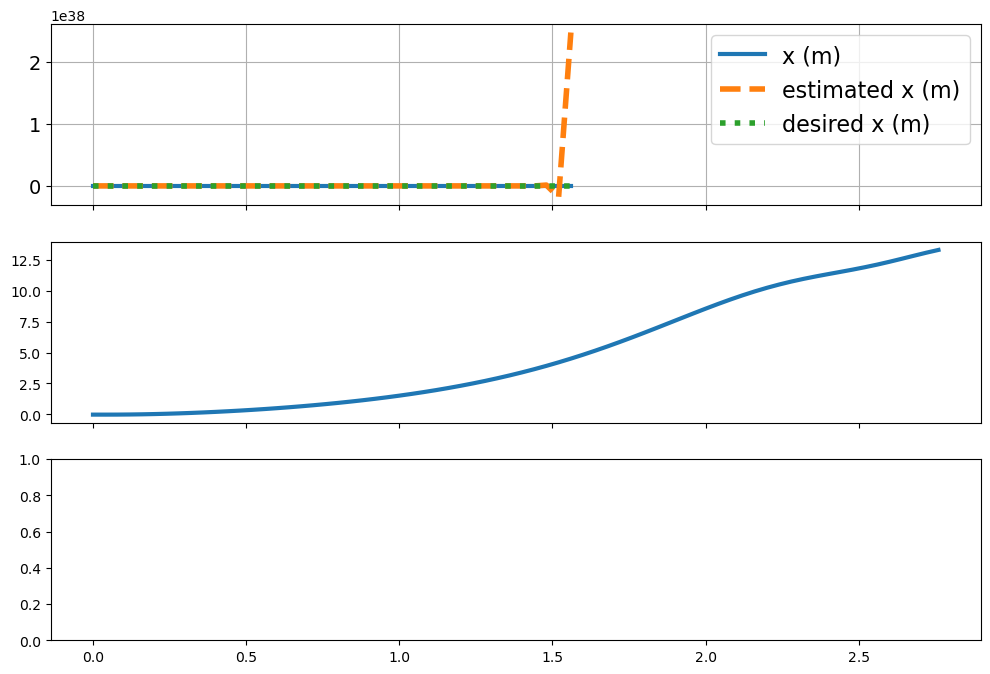

In [ ]:
p_x_est = data['xhat'][:, 0]
p_y_est = data['xhat'][:, 1]
p_z_est = data['xhat'][:, 2]

p_x_des = data['xdes'][:, 0]
p_y_des = data['xdes'][:, 1]
p_z_des = data['xdes'][:, 2]

p_x_est = p_x_est[:-30]
p_y_est = p_y_est[:-30]
p_z_est = p_z_est[:-30]
p_x_des = p_x_des[:-30]
p_y_des = p_y_des[:-30]
p_z_des = p_z_des[:-30]

#p_x_ring = data['ring'][:, 0]
#p_y_ring = data['ring'][:, 1]
#p_z_ring = data['ring'][:, 2]

# Create a figure with subplots that all share the same x-axis
fig, (ax_px, ax_py, ax_pz) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax_px.plot(data['t'][:-30], data['p_x'][:-30], label='x (m)', linewidth=3)
ax_px.plot(data['t'][:-30], p_x_est, '--', label='estimated x (m)', linewidth=4)
ax_px.plot(data['t'][:-30], p_x_des, ':', label='desired x (m)', linewidth=4)
# ax_px.plot(data['t'], p_x_ring, '-.', label='ring x (m)', linewidth=3)
ax_px.grid()
ax_px.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_px.tick_params(labelsize=14)

ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=3)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_des, ':', label='desired y (m)', linewidth=4)
# ax_py.plot(data['t'], p_y_ring, '-.', label='ring y (m)', linewidth=3)
ax_py.grid()
ax_py.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_py.tick_params(labelsize=14)

ax_pz.plot(data['t'], data['p_z'], label='z (m)', linewidth=3)
ax_pz.plot(data['t'], p_z_est, '--', label='estimated z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_des, ':', label='desired z (m)', linewidth=4)
# ax_pz.plot(data['t'], p_z_ring, '-.', label='ring z (m)', linewidth=3)
ax_pz.grid()
ax_pz.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pz.tick_params(labelsize=14)

# Set shared x-axis properties
ax_pz.set_xlabel('time (s)', fontsize=20)
# ax_pz.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Logging containers
compute_times = []
finish_times = []
success_flags = []
controller_errors = []
observer_errors = []

num_trials = 100  

for _ in range(num_trials):
    seed = secrets.randbits(32)
    print(seed)
    simulator = ae353_drone.Simulator(seed=seed, display_pybullet=False)
    simulator.add_drone(Controller, 'wark', 'AE353FINALPROJ.jpg')
    simulator.reset()
    simulator.run(max_time=70., print_debug=False)

    did_fail, did_finish, t_finish = simulator.get_result('wark')
    data = simulator.get_data('wark')

    # Compute time
    compute_times.extend(data['run_time'])

    # Completion
    success_flags.append(int(did_finish and not did_fail))
    finish_times.append(t_finish if did_finish else np.nan)

    # Position logs
    actual_pos = np.stack([data['p_x'], data['p_y'], data['p_z']], axis=1)
    est_pos = np.array(data['xhat'])[:, :3]

    # Handle desired pos
    if isinstance(data['pos_ring'], list) or np.ndim(data['pos_ring']) == 2:
        desired_array = np.array(data['pos_ring'])  # already a trajectory
    else:
        desired_array = np.tile(data['pos_ring'], (len(actual_pos), 1))  # constant

    # Align lengths
    N = min(len(actual_pos), len(est_pos), len(desired_array))
    actual_pos = actual_pos[:N]
    est_pos = est_pos[:N]
    desired_array = desired_array[:N]

    # Errors
    controller_err = np.linalg.norm(desired_array - actual_pos, axis=1)
    observer_err = np.linalg.norm(est_pos - actual_pos, axis=1)
    controller_errors.extend(controller_err)
    observer_errors.extend(observer_err)

# --- Plot 4 Subplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. Computation Time per Step
axes[0].hist(compute_times, bins=30, color='orange', edgecolor='black')
axes[0].set_title("Computation Time per Step")
axes[0].set_xlabel("Time per Step (s)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# 2. Completion Times
valid_times = [t for t in finish_times if not np.isnan(t)]
axes[1].hist(valid_times, bins=10, color='salmon', edgecolor='black')
axes[1].set_title("Completion Times (Successful Flights Only)")
axes[1].set_xlabel("Completion Time (s)")
axes[1].set_ylabel("Number of Flights")
axes[1].grid(True)

# 3. Controller Tracking Error
axes[2].hist(controller_errors, bins=30, color='skyblue', edgecolor='black')
axes[2].set_title("Controller Tracking Error")
axes[2].set_xlabel("Position Error (m)")
axes[2].set_ylabel("Frequency")
axes[2].grid(True)

# 4. Observer Estimation Error
axes[3].hist(observer_errors, bins=30, color='lightgreen', edgecolor='black')
axes[3].set_title("Observer Estimation Error")
axes[3].set_xlabel("Estimation Error (m)")
axes[3].set_ylabel("Frequency")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# --- Summary Stats ---
print(f"\nSummary for {num_trials} trials:")
print(f"Success Rate: {np.mean(success_flags) * 100:.1f}%")
if valid_times:
    print(f"Average Completion Time: {np.mean(valid_times):.2f} s")
    print(f"Fastest: {np.min(valid_times):.2f} s | Slowest: {np.max(valid_times):.2f} s")
else:
    print("No successful flights.")



3658317019
Failed to add wark because of the following error:

Traceback (most recent call last):
  File "c:\Users\ellay\OneDrive\Desktop\AE_353\ae353-sp25\projects\04_drone\ae353_drone.py", line 190, in add_drone
    texture_id = self.bullet_client.loadTexture(image)
pybullet.error: Error loading texture

The simulator has no drone with name "wark". The simulator has no drones at all, in fact.


TypeError: cannot unpack non-iterable NoneType object